In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
from tqdm import tqdm
import pdb
import os

from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Getting Data

In [2]:
# obtaining condition labels
labels_path = 'data/medical_abstracts_TC_corpus/medical_tc_labels.csv'
df_labels = pd.read_csv(labels_path)
df_labels

,condition_label,condition_name
0,1,neoplasms
1,2,digestive system diseases
2,3,nervous system diseases
3,4,cardiovascular diseases
4,5,general pathological conditions


In [3]:
# loading training data
train_path = '../../data/medical_abstracts_TC_corpus/medical_tc_train.csv'
df_train = pd.read_csv(train_path)
df_train.head()

,condition_label,medical_abstract
0,5,Tissue changes around loose prostheses. A cani...
1,1,Neuropeptide Y and neuron-specific enolase lev...
2,2,"Sexually transmitted diseases of the colon, re..."
3,1,Lipolytic factors associated with murine and h...
4,3,Does carotid restenosis predict an increased r...


In [4]:
# loading test data
test_path = '../../data/medical_abstracts_TC_corpus/medical_tc_test.csv'
df_test = pd.read_csv(test_path)
df_test.head()

,condition_label,medical_abstract
0,3,Obstructive sleep apnea following topical orop...
1,5,Neutrophil function and pyogenic infections in...
2,5,A phase II study of combined methotrexate and ...
3,1,Flow cytometric DNA analysis of parathyroid tu...
4,4,Paraneoplastic vasculitic neuropathy: a treata...


In [5]:
# add true/false test column to be used as a mask later
df_train['test'] = False
df_test['test'] = True

In [6]:
# combine train and test dataframe
df_all = pd.concat([df_train, df_test], axis=0)
df_all.reset_index(drop=True, inplace=True)  # fix index
assert len(df_all) == len(df_train) + len(df_test)  # sanity check

In [7]:
# fixing labels so pytorch cross entropy doesn't complain
df_all.condition_label = df_all.condition_label - 1
df_labels.condition_label = df_labels.condition_label - 1

In [8]:
df_all.head()

,condition_label,medical_abstract,test
0,4,Tissue changes around loose prostheses. A cani...,False
1,0,Neuropeptide Y and neuron-specific enolase lev...,False
2,1,"Sexually transmitted diseases of the colon, re...",False
3,0,Lipolytic factors associated with murine and h...,False
4,2,Does carotid restenosis predict an increased r...,False


In [9]:
# mapping from class name to value for later
condition_names = list(df_labels.condition_name)
condition_labels = df_labels.condition_label
class_map = {condition_names[i]: condition_labels[i] for i in range(5)}
class_map_inv = {v: k for k, v in class_map.items()}
class_map, class_map_inv

({'neoplasms': 0,
  'digestive system diseases': 1,
  'nervous system diseases': 2,
  'cardiovascular diseases': 3,
  'general pathological conditions': 4},
 {0: 'neoplasms',
  1: 'digestive system diseases',
  2: 'nervous system diseases',
  3: 'cardiovascular diseases',
  4: 'general pathological conditions'})

In [10]:
del df_train, df_test

# Define Hyperparameters

In [11]:
bert_model_name = 'bert-base-uncased'
num_classes = 5
max_length = 512 # this will truncate many of the texts (avg length: 180 words). Should try with BERT's maximum token length of 512
batch_size = 15
num_epochs = 15
learning_rate = 0.000001

# Building Datasets/Dataloader

In [12]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length, device=torch.device('cpu')):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.device = device
        self.unique_labels = list(torch.from_numpy(np.unique(labels)))
        
    def __len__(self):
        return len(self.texts)
        
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten().to(self.device), 
                'attention_mask': encoding['attention_mask'].flatten().to(self.device), 
                'label': torch.tensor(label).to(self.device)}

In [13]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print('Device:', device)

Device: mps


In [14]:
# splitting df_all into train and test data and labels
train_texts = list(df_all[~df_all.test].medical_abstract)
train_labels = list(df_all[~df_all.test].condition_label)
test_texts = list(df_all[df_all.test].medical_abstract)
test_labels = list(df_all[df_all.test].condition_label)

assert len(train_texts) == len(train_labels)
assert len(test_texts) == len(test_labels)
assert len(train_texts + test_texts) == len(df_all)

In [15]:
# tokenizer
# tokenizer = BertTokenizer.from_pretrained(bert_model_name) 
tokenizer = AutoTokenizer.from_pretrained('medicalai/ClinicalBERT')
# tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')

# create datasets and dataloaders 
train_dataset = TextClassificationDataset(texts=train_texts, labels=train_labels, tokenizer=tokenizer, 
                                          max_length=max_length, device=device)
test_dataset = TextClassificationDataset(texts=test_texts, labels=test_labels, tokenizer=tokenizer, 
                                         max_length=max_length, device=device)

assert len(train_dataset) == len(train_texts) # yes, I AM that paranoid.
assert len(test_dataset) == len(test_texts)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)

assert len(train_dataloader) == math.ceil(len(train_texts) / batch_size) 
assert len(test_dataloader) == math.ceil(len(test_texts) / batch_size)  # pytorch creates a partial batch if there is extra, so I round up

In [16]:
# for visualizing data
dummy_dataset = TextClassificationDataset(texts=list(df_all.medical_abstract), 
                                          labels=list(df_all.condition_label),
                                          tokenizer = tokenizer,
                                          max_length=max_length)
dummy_dataloader = DataLoader(dataset=dummy_dataset, batch_size=batch_size)

In [17]:
# obtain number of tokens and labels for all texts
all_num_tokens = np.zeros(shape=(len(dummy_dataloader.dataset)))
all_labels = np.zeros(shape=(len(dummy_dataloader.dataset)))
for batch_idx, batch in enumerate(tqdm(iter(dummy_dataloader))):
    labels = np.array(batch['label'].cpu())
    all_labels[batch_idx*batch_size : (batch_idx+1)*batch_size] = labels
    token_counts = torch.count_nonzero(batch['input_ids'], axis=1)
    all_num_tokens[batch_idx*batch_size : (batch_idx+1)*batch_size] = token_counts

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 963/963 [00:09<00:00, 98.64it/s]


In [18]:
# view descriptive statistics for number of tokens
pd.Series(data=all_num_tokens).describe()

count    14438.000000
mean       295.956989
std        121.396574
min         42.000000
25%        200.000000
50%        290.000000
75%        390.000000
max        512.000000
dtype: float64

Text(0.5, 9.444444444444438, 'Number of Tokens')

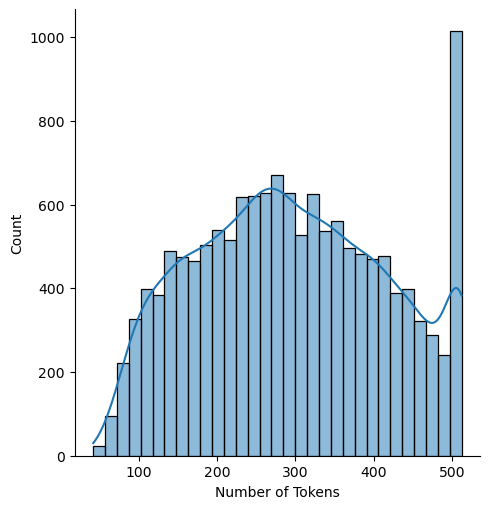

In [19]:
sns.displot(data=all_num_tokens, kde=True)
plt.xlabel('Number of Tokens')

In [20]:
# creating a dataframe for analysis
labels_and_token_counts_df = pd.DataFrame({'Token_Count': all_num_tokens, 'Label': all_labels})
labels_and_token_counts_df['condition_label'] = labels_and_token_counts_df['Label'].apply(lambda x: class_map_inv[x])
labels_and_token_counts_df.head()

,Token_Count,Label,condition_label
0,231.0,4.0,general pathological conditions
1,320.0,0.0,neoplasms
2,418.0,1.0,digestive system diseases
3,225.0,0.0,neoplasms
4,365.0,2.0,nervous system diseases


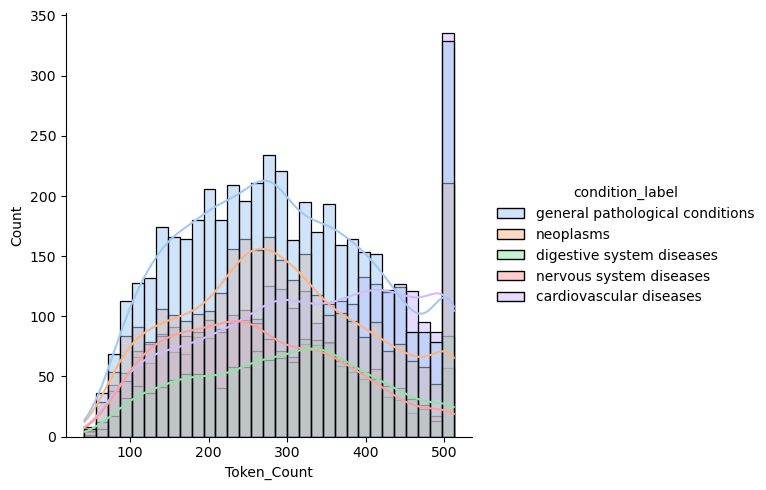

In [21]:
# visualize token counts for different conditions
sns.displot(data=labels_and_token_counts_df, x='Token_Count', hue='condition_label', kde=True, palette='pastel')

In [22]:
del labels_and_token_counts_df, all_labels, all_num_tokens, dummy_dataset, dummy_dataloader

# Creating Model

In [23]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1) 
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits  # 'logits' = raw outputs before softmax

class ClinicalBERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ClinicalBERTClassifier, self).__init__()
        self.clinical_bert = AutoModel.from_pretrained('medicalai/ClinicalBERT') # could make this more modular but for now just getting it working
        self.dropout = nn.Dropout(0.1)
        self.pooler_layer = nn.Linear(in_features=768, out_features=768)
        self.fc = nn.Linear(in_features=768, out_features=num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.clinical_bert(input_ids=input_ids, attention_mask=attention_mask)
        # get classification tokens (the first one) for all items in batch
        cls_token = outputs.last_hidden_state[:, 0]
        pooled_output = F.tanh(self.pooler_layer(cls_token))  # this is how BERT family models do it, dont ask me why
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

class DistilBERTClassifier(nn.Module):
    # condensed, more efficient version of BERT
    def __init__(self, num_classes):
        super(DistilBERTClassifier, self).__init__()
        self.distilbert = AutoModel.from_pretrained('distilbert/distilbert-base-uncased') 
        self.dropout = nn.Dropout(0.1) 
        self.pooler_layer = nn.Linear(in_features=self.distilbert.config.hidden_size, out_features=self.distilbert.config.hidden_size)
        self.fc = nn.Linear(self.distilbert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0]
        pooled_output = F.tanh(self.pooler_layer(cls_token))  # this is how BERT family models do it, dont ask me why
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [24]:
# instantiate model and move to specified device
# model = BERTClassifier(bert_model_name=bert_model_name, num_classes=num_classes)
# model = model.to(device)

model = ClinicalBERTClassifier(num_classes=num_classes)
model = model.to(device)

# model = DistilBERTClassifier(num_classes=num_classes)
# model = model.to(device)

In [25]:
# define optimizer and loss function
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

# Training Model

In [26]:
from utils.misc_utils import date_n_time

In [27]:
# training 
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    """Train a PyTorch model for one epoch on a given dataloader

    Args:
        dataloader (torch.utils.data.DataLoader): a pytorch dataloader object
        model (torch.nn.Module): a pytorch model object
        loss_fn (torch.optim): a pytorch loss function object
        optimizer (torch.optim): a pytorch optimizer object

    Returns:
        last_loss (float): loss for the last batch
    """
    # set model to train mode
    model.train()
    
    running_loss = 0.
    last_loss = 0.
    
    start = time.time()
    
    for batch_idx, batch in enumerate(iter(dataloader)):
        batch_input_ids = batch['input_ids']
        batch_attention_mask = batch['attention_mask']
        batch_labels = batch['label']

        # Zero gradients
        optimizer.zero_grad()

        # Make predictions for this batch
        batch_outputs = model(batch_input_ids, batch_attention_mask)

        # Compute the loss and its gradients
        loss = loss_fn(batch_outputs, batch_labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

        num_batches_per_update = 25  # number of batches for each print statement
        
        if batch_idx % num_batches_per_update == 0 and not batch_idx == 0:
            last_loss = running_loss / num_batches_per_update # loss per batch
            print(f'Running average loss at batch {batch_idx} : {last_loss}, Time: {time.time()-start}')
            running_loss = 0.
            start=time.time()

    return last_loss

In [28]:
# validation
def validate_classification_model(dataloader, model, loss_fn, device):
    """Validate a classification model on a given dataset, return both mean loss and class-specific losses

    Args:
        dataloader (torch.utils.data.DataLoader): a pytorch dataloader object. Must have a dataset attribute with unique_labels: list(torch.Tensor)
        model (torch.nn.Module): a pytorch model object
        loss_fn (torch.optim): a pytorch loss function object
        device (torch.device): a pytorch device object

    Returns:
        mean_validation_loss (float): mean loss across all batches
        losses_for_unique_labels (dict): dictionary of losses for each unique label
    """
    with torch.no_grad():
        # set model to evaluation mode
        model.eval()
        
        batch_loss = 0
        batch_loss_list = []
    
        unique_labels = dataloader.dataset.unique_labels
        losses_for_unique_labels_raw = {unique_label: [] for unique_label in unique_labels}
        
        for batch in tqdm(iter(dataloader)):
            # Breaking up batch into components
            batch_input_ids = batch['input_ids']
            batch_attention_mask = batch['attention_mask']
            batch_labels = batch['label']
    
            # Make predictions for this batch
            batch_outputs = model(batch_input_ids, batch_attention_mask).detach()
            
            # Compute the loss
            loss = loss_fn(batch_outputs, batch_labels)
    
            # get loss for each label
            for unique_label in unique_labels:
                if any(batch_labels == unique_label):
                    batch_idxs_for_unique_label = batch_labels == unique_label
                    
                    batch_outputs_for_unique_label = batch_outputs[batch_idxs_for_unique_label]
                    num_samples_in_batch = len(batch_outputs_for_unique_label)
                    batch_targets_for_unique_label = unique_label.repeat(1, num_samples_in_batch).flatten().to(device)
                   
                    loss_for_unique_label = loss_fn(batch_outputs_for_unique_label, batch_targets_for_unique_label)
                    loss_for_unique_label = loss_for_unique_label.item()
                else:
                    loss_for_unique_label = 0
                    num_samples_in_batch = 0
                    
                losses_for_unique_labels_raw[unique_label].append((loss_for_unique_label, num_samples_in_batch))
            
            # Extract batch loss as float
            batch_loss = loss.item()
    
            # add batch loss to running list
            batch_loss_list.append(batch_loss) 
    
        losses_for_unique_labels = {unique_label: [] for unique_label in unique_labels}
    
        # obtain losses for each class by aggregating individual batch losses
        for unique_label in unique_labels:
            loss_list_for_unique_label_raw = losses_for_unique_labels_raw[unique_label]
            total_samples = sum([pair[1] for pair in loss_list_for_unique_label_raw])
            loss_weights = [pair[1]/total_samples for pair in loss_list_for_unique_label_raw]
            assert sum(loss_weights) == 1 
            weighted_losses = [pair[0] * loss_weights[i] for i, pair in enumerate(loss_list_for_unique_label_raw)]
            aggregated_class_loss = sum(weighted_losses)
            losses_for_unique_labels[unique_label] = aggregated_class_loss
    
        mean_validation_loss = np.mean(batch_loss_list)
    return mean_validation_loss, losses_for_unique_labels


In [29]:
all_train_loss = []
all_test_loss = []
all_class_test_losses = {label: [] for label in list(class_map.values())}
all_model_paths = []
all_model_filenames = []

for epoch in range(1, num_epochs+1):
    print("-"*60)
    print("Epoch ", epoch)

    # train
    print("Starting Model Training...")
    last_train_loss = train_one_epoch(train_dataloader, model, loss_fn, optimizer)
    print("Last train loss: ", last_train_loss)

    all_train_loss.append(last_train_loss)

    # validation
    print("Starting Model Testing...")
    mean_test_loss, losses_for_unique_labels = validate_classification_model(test_dataloader, model, loss_fn, device)
    print("Mean test loss: ", mean_test_loss)
    print(f"Losses for individual classes: {losses_for_unique_labels}")

    all_test_loss.append(mean_test_loss)

    # record individual class labels
    for label in losses_for_unique_labels:
        all_class_test_losses[label.item()].append(losses_for_unique_labels[label])

    # saving model
    print("Saving model...")
    model_save_directory = 'models/'
    model_name = f'medical_abstract_bert_epoch_{epoch}_time_{date_n_time()}'
    model_path = os.path.join(model_save_directory, model_name)
    torch.save(model, model_path)

    all_model_filenames.append(model_path)
    assert os.path.exists(model_path), 'Model failed to save'
    print("Model saved")

------------------------------------------------------------
Epoch  1
Starting Model Training...
Running average loss at batch 25 : 1.635744571685791, Time: 30.434940814971924
Running average loss at batch 50 : 1.557992558479309, Time: 28.56134605407715
Running average loss at batch 75 : 1.5550855588912964, Time: 28.56787610054016
Running average loss at batch 100 : 1.5439488506317138, Time: 28.567919969558716
Running average loss at batch 125 : 1.5289052534103393, Time: 28.6195068359375
Running average loss at batch 150 : 1.535070013999939, Time: 28.547824144363403
Running average loss at batch 175 : 1.5449410581588745, Time: 28.53209686279297
Running average loss at batch 200 : 1.4994047784805298, Time: 28.53999614715576
Running average loss at batch 225 : 1.516457815170288, Time: 28.55300998687744
Running average loss at batch 250 : 1.5252134704589844, Time: 28.560606002807617
Running average loss at batch 275 : 1.4986628580093384, Time: 28.52659511566162
Running average loss at bat

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [01:12<00:00,  2.65it/s]


Mean test loss:  1.0299017747449133
Losses for individual classes: {tensor(0): 0.8020317484793882, tensor(1): 1.336814244056625, tensor(2): 1.3848843720052149, tensor(3): 0.6898941752363424, tensor(4): 1.1566339352872692}
Saving model...
Model saved
------------------------------------------------------------
Epoch  2
Starting Model Training...
Running average loss at batch 25 : 1.0840781950950622, Time: 32.9367790222168
Running average loss at batch 50 : 0.980192039012909, Time: 30.36430811882019
Running average loss at batch 75 : 1.002549605369568, Time: 30.118556022644043
Running average loss at batch 100 : 0.9931549286842346, Time: 30.231812238693237
Running average loss at batch 125 : 0.9925349903106689, Time: 29.492048740386963
Running average loss at batch 150 : 1.0025125980377196, Time: 29.606667041778564
Running average loss at batch 175 : 0.9731469225883483, Time: 29.532864093780518
Running average loss at batch 200 : 0.9950228524208069, Time: 29.38778805732727
Running averag

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [01:12<00:00,  2.65it/s]


Mean test loss:  0.9204178687204351
Losses for individual classes: {tensor(0): 0.6434474440782932, tensor(1): 1.1094704920232894, tensor(2): 1.25801235390948, tensor(3): 0.6478358927808825, tensor(4): 1.0801684502570363}
Saving model...
Model saved
------------------------------------------------------------
Epoch  3
Starting Model Training...
Running average loss at batch 25 : 0.9510535287857056, Time: 31.717116117477417
Running average loss at batch 50 : 0.8485152518749237, Time: 30.716036081314087
Running average loss at batch 75 : 0.9707508897781372, Time: 30.98529291152954
Running average loss at batch 100 : 0.852896625995636, Time: 30.7072811126709
Running average loss at batch 125 : 0.9762325000762939, Time: 31.37814497947693
Running average loss at batch 150 : 0.9069528007507324, Time: 31.131914854049683
Running average loss at batch 175 : 0.865902669429779, Time: 30.509536027908325
Running average loss at batch 200 : 0.8628210985660553, Time: 30.23818016052246
Running average 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [01:12<00:00,  2.68it/s]


Mean test loss:  0.8960670234316989
Losses for individual classes: {tensor(0): 0.638631305376312, tensor(1): 1.0056438588577767, tensor(2): 1.1588453114032746, tensor(3): 0.5661568806430356, tensor(4): 1.1342226420989518}
Saving model...
Model saved
------------------------------------------------------------
Epoch  4
Starting Model Training...
Running average loss at batch 25 : 0.872676146030426, Time: 32.54622793197632
Running average loss at batch 50 : 0.857395794391632, Time: 31.09400725364685
Running average loss at batch 75 : 0.8826529705524444, Time: 31.35027503967285
Running average loss at batch 100 : 0.8476196527481079, Time: 31.294562101364136
Running average loss at batch 125 : 0.8619783282279968, Time: 30.215526342391968
Running average loss at batch 150 : 0.8583243131637573, Time: 29.024205923080444
Running average loss at batch 175 : 0.8538026452064514, Time: 30.318683862686157
Running average loss at batch 200 : 0.8300542378425598, Time: 29.885596752166748
Running avera

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [01:12<00:00,  2.66it/s]


Mean test loss:  0.8831470593269625
Losses for individual classes: {tensor(0): 0.6393638002976045, tensor(1): 0.853243344105207, tensor(2): 1.172457786813959, tensor(3): 0.6363497642952888, tensor(4): 1.091445015974025}
Saving model...
Model saved
------------------------------------------------------------
Epoch  5
Starting Model Training...
Running average loss at batch 25 : 0.9356976413726806, Time: 32.30155801773071
Running average loss at batch 50 : 0.8224737930297852, Time: 29.785189151763916
Running average loss at batch 75 : 0.808561601638794, Time: 30.30128312110901
Running average loss at batch 100 : 0.8679038834571838, Time: 30.42488670349121
Running average loss at batch 125 : 0.8386512279510498, Time: 29.643435955047607
Running average loss at batch 150 : 0.8456904435157776, Time: 30.46576499938965
Running average loss at batch 175 : 0.8079350113868713, Time: 30.304883241653442
Running average loss at batch 200 : 0.9001362657546997, Time: 29.4925639629364
Running average l

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [01:12<00:00,  2.68it/s]


Mean test loss:  0.8710156890703606
Losses for individual classes: {tensor(0): 0.632831591777327, tensor(1): 1.011498657357334, tensor(2): 1.0663797906466892, tensor(3): 0.5723730074211223, tensor(4): 1.0932478766721692}
Saving model...
Model saved
------------------------------------------------------------
Epoch  6
Starting Model Training...
Running average loss at batch 25 : 0.8613919758796692, Time: 31.30076813697815
Running average loss at batch 50 : 0.7876828813552856, Time: 29.639432907104492
Running average loss at batch 75 : 0.8457888007164002, Time: 29.393568992614746
Running average loss at batch 100 : 0.7895008134841919, Time: 29.538832902908325
Running average loss at batch 125 : 0.8388276362419128, Time: 30.023919820785522
Running average loss at batch 150 : 0.7697545814514161, Time: 30.38129496574402
Running average loss at batch 175 : 0.8540412449836731, Time: 30.702411890029907
Running average loss at batch 200 : 0.8769172763824463, Time: 28.995568990707397
Running ave

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [01:12<00:00,  2.68it/s]


Mean test loss:  0.8620082802414276
Losses for individual classes: {tensor(0): 0.611115330179909, tensor(1): 0.9595179160602116, tensor(2): 1.0914281089971591, tensor(3): 0.6329463316402475, tensor(4): 1.047546857198493}
Saving model...
Model saved
------------------------------------------------------------
Epoch  7
Starting Model Training...
Running average loss at batch 25 : 0.8914915001392365, Time: 31.356485843658447
Running average loss at batch 50 : 0.9139544653892517, Time: 30.358488082885742
Running average loss at batch 75 : 0.8704789042472839, Time: 31.060100317001343
Running average loss at batch 100 : 0.7801800835132598, Time: 30.39665198326111
Running average loss at batch 125 : 0.8408584833145142, Time: 30.4481041431427
Running average loss at batch 150 : 0.8042048287391662, Time: 29.24985384941101
Running average loss at batch 175 : 0.8083863031864166, Time: 30.73941922187805
Running average loss at batch 200 : 0.7922839045524597, Time: 31.338112115859985
Running averag

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [01:12<00:00,  2.67it/s]


Mean test loss:  0.8676415144470689
Losses for individual classes: {tensor(0): 0.5510618240818217, tensor(1): 1.0101810365317259, tensor(2): 1.0117040590032356, tensor(3): 0.5384870797090354, tensor(4): 1.1804619752777727}
Saving model...
Model saved
------------------------------------------------------------
Epoch  8
Starting Model Training...
Running average loss at batch 25 : 0.8712189817428588, Time: 31.8888099193573
Running average loss at batch 50 : 0.8112926614284516, Time: 31.535824060440063
Running average loss at batch 75 : 0.7229169893264771, Time: 30.23819613456726
Running average loss at batch 100 : 0.7130086719989777, Time: 28.957735061645508
Running average loss at batch 125 : 0.8145209491252899, Time: 29.31100106239319
Running average loss at batch 150 : 0.8875897789001465, Time: 29.201727867126465
Running average loss at batch 175 : 0.7545937824249268, Time: 30.377239227294922
Running average loss at batch 200 : 0.8187977910041809, Time: 29.342890977859497
Running ave

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [01:12<00:00,  2.67it/s]


Mean test loss:  0.8553378971129502
Losses for individual classes: {tensor(0): 0.6526972481401234, tensor(1): 1.0240708637397027, tensor(2): 1.0083616243941442, tensor(3): 0.6015274995540987, tensor(4): 1.0330391932321512}
Saving model...
Model saved
------------------------------------------------------------
Epoch  9
Starting Model Training...
Running average loss at batch 25 : 0.725107387304306, Time: 31.586606979370117
Running average loss at batch 50 : 0.8000926876068115, Time: 29.71233320236206
Running average loss at batch 75 : 0.7604532980918884, Time: 28.97638201713562
Running average loss at batch 100 : 0.7240973734855651, Time: 29.719057083129883
Running average loss at batch 125 : 0.7840464985370637, Time: 29.549668073654175
Running average loss at batch 150 : 0.7714372026920319, Time: 29.311761140823364
Running average loss at batch 175 : 0.7618498396873474, Time: 29.43565320968628
Running average loss at batch 200 : 0.8690536522865295, Time: 30.087700843811035
Running ave

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [01:12<00:00,  2.67it/s]


Mean test loss:  0.8670201105466161
Losses for individual classes: {tensor(0): 0.5707183545352347, tensor(1): 0.8557368952992768, tensor(2): 1.1114459519262438, tensor(3): 0.5440406867409827, tensor(4): 1.1696178522212946}
Saving model...
Model saved
------------------------------------------------------------
Epoch  10
Starting Model Training...
Running average loss at batch 25 : 0.7745092010498047, Time: 31.574887990951538
Running average loss at batch 50 : 0.7905156874656677, Time: 30.00316309928894
Running average loss at batch 75 : 0.7802384519577026, Time: 29.271023988723755
Running average loss at batch 100 : 0.7290486240386963, Time: 30.052528142929077
Running average loss at batch 125 : 0.8363538563251496, Time: 30.175158977508545
Running average loss at batch 150 : 0.7029345083236694, Time: 29.21470284461975
Running average loss at batch 175 : 0.7404656720161438, Time: 29.037434816360474
Running average loss at batch 200 : 0.7636930525302887, Time: 29.517770051956177
Running 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [01:12<00:00,  2.68it/s]


Mean test loss:  0.8587854177222969
Losses for individual classes: {tensor(0): 0.6196525588066657, tensor(1): 0.8764348423799943, tensor(2): 1.061098733583054, tensor(3): 0.605033055662376, tensor(4): 1.0870194829899613}
Saving model...
Model saved
------------------------------------------------------------
Epoch  11
Starting Model Training...
Running average loss at batch 25 : 0.7805898070335389, Time: 30.707478761672974
Running average loss at batch 50 : 0.7230355882644653, Time: 29.40225601196289
Running average loss at batch 75 : 0.6954945528507233, Time: 29.082183837890625
Running average loss at batch 100 : 0.794986116886139, Time: 30.595723152160645
Running average loss at batch 125 : 0.7548433315753936, Time: 29.382511854171753
Running average loss at batch 150 : 0.74522385597229, Time: 30.13541603088379
Running average loss at batch 175 : 0.7097259736061097, Time: 29.335975885391235
Running average loss at batch 200 : 0.7772066116333007, Time: 29.635420322418213
Running avera

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [01:12<00:00,  2.67it/s]


Mean test loss:  0.8646038917371028
Losses for individual classes: {tensor(0): 0.5935950619632034, tensor(1): 0.8824742983615518, tensor(2): 1.1150941155560605, tensor(3): 0.5615146146079556, tensor(4): 1.1257996823673566}
Saving model...
Model saved
------------------------------------------------------------
Epoch  12
Starting Model Training...
Running average loss at batch 25 : 0.7775204467773438, Time: 30.937830209732056
Running average loss at batch 50 : 0.7283130550384521, Time: 30.693571090698242
Running average loss at batch 75 : 0.822617713212967, Time: 29.93395972251892
Running average loss at batch 100 : 0.7652543985843658, Time: 29.13515591621399
Running average loss at batch 125 : 0.7449101221561432, Time: 29.51169514656067
Running average loss at batch 150 : 0.7407585799694061, Time: 29.196527004241943
Running average loss at batch 175 : 0.698026602268219, Time: 30.415645837783813
Running average loss at batch 200 : 0.6995137047767639, Time: 29.575135946273804
Running ave

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [01:12<00:00,  2.67it/s]


Mean test loss:  0.8583064432897716
Losses for individual classes: {tensor(0): 0.6335210559821995, tensor(1): 1.0454810948475548, tensor(2): 0.9761250929786013, tensor(3): 0.6930663459002971, tensor(4): 1.001820764807707}
Saving model...
Model saved
------------------------------------------------------------
Epoch  13
Starting Model Training...
Running average loss at batch 25 : 0.7092969191074371, Time: 31.486897945404053
Running average loss at batch 50 : 0.7094605255126953, Time: 30.50965690612793
Running average loss at batch 75 : 0.7426083850860595, Time: 29.900763034820557
Running average loss at batch 100 : 0.7737632489204407, Time: 30.63442373275757
Running average loss at batch 125 : 0.6822906398773193, Time: 30.819960832595825
Running average loss at batch 150 : 0.7109744560718536, Time: 30.931535005569458
Running average loss at batch 175 : 0.6933079946041107, Time: 29.523020029067993
Running average loss at batch 200 : 0.7070475673675537, Time: 31.082699060440063
Running a

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [01:12<00:00,  2.67it/s]


Mean test loss:  0.8634679405491587
Losses for individual classes: {tensor(0): 0.6614225730888463, tensor(1): 0.9327749149954837, tensor(2): 0.9845418190414256, tensor(3): 0.6420095283049541, tensor(4): 1.0627967991423284}
Saving model...
Model saved
------------------------------------------------------------
Epoch  14
Starting Model Training...
Running average loss at batch 25 : 0.6475934755802154, Time: 32.30849289894104
Running average loss at batch 50 : 0.7726588952541351, Time: 30.107579231262207
Running average loss at batch 75 : 0.7156690096855164, Time: 29.871337890625
Running average loss at batch 100 : 0.685978717803955, Time: 29.087994813919067
Running average loss at batch 125 : 0.6583772814273834, Time: 29.543779134750366
Running average loss at batch 150 : 0.7870082902908325, Time: 29.574587106704712
Running average loss at batch 175 : 0.7246316552162171, Time: 29.571223974227905
Running average loss at batch 200 : 0.7292926800251007, Time: 29.346237897872925
Running ave

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [01:12<00:00,  2.67it/s]


Mean test loss:  0.8797105966145511
Losses for individual classes: {tensor(0): 0.7125120601288704, tensor(1): 0.8353069002761888, tensor(2): 0.9724213152736813, tensor(3): 0.5611498237816526, tensor(4): 1.1644481194596137}
Saving model...
Model saved
------------------------------------------------------------
Epoch  15
Starting Model Training...
Running average loss at batch 25 : 0.6775058948993683, Time: 32.687029123306274
Running average loss at batch 50 : 0.7278174841403962, Time: 30.537492990493774
Running average loss at batch 75 : 0.7101786506175994, Time: 29.226326942443848
Running average loss at batch 100 : 0.6240986263751984, Time: 30.51653003692627
Running average loss at batch 125 : 0.7643059003353119, Time: 30.225380182266235
Running average loss at batch 150 : 0.7641644477844238, Time: 30.142374992370605
Running average loss at batch 175 : 0.6762126195430755, Time: 30.248417139053345
Running average loss at batch 200 : 0.7576944708824158, Time: 29.092849254608154
Running

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [01:12<00:00,  2.67it/s]


Mean test loss:  0.8774626795492024
Losses for individual classes: {tensor(0): 0.6102084543020427, tensor(1): 0.9520120007487444, tensor(2): 0.9967723401335927, tensor(3): 0.6227217104866124, tensor(4): 1.139961085042894}
Saving model...
Model saved


In [30]:
df_losses = pd.DataFrame({'Train': all_train_loss, 'Test': all_test_loss})
df_losses.head()

,Train,Test
0,1.071933,1.029902
1,0.876241,0.920418
2,0.861395,0.896067
3,0.867330,0.883147
4,0.777833,0.871016


Text(0.5, 1.0, 'Train and Test Loss for Medical Abstract Classification with BERT')

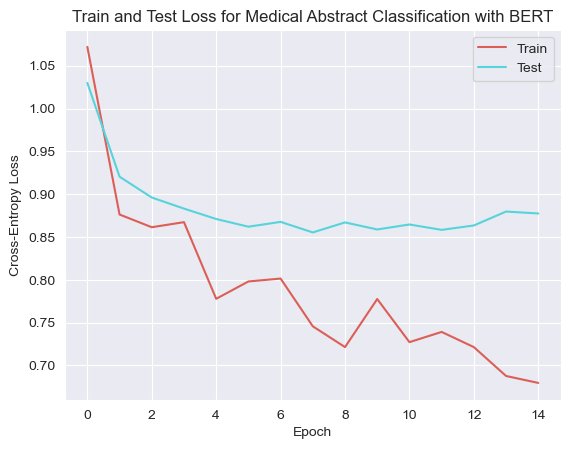

In [31]:
sns.set_style("darkgrid")
sns.lineplot(data=df_losses[['Train', 'Test']], palette='hls', dashes=False)
plt.ylabel('Cross-Entropy Loss')
plt.xlabel('Epoch')
plt.title('Train and Test Loss for Medical Abstract Classification with BERT')

# filename_train_and_valid="Train and Validation Loss for Immune Cell Image Classification Using Transfer Learning on Resnet-18".replace(" ", "_")
# plt.savefig(fname=filename_train_and_valid, dpi=1000)

In [39]:
# obtaining the minimum test loss
df_losses.iloc[df_losses.Test.argmin()]

Train    0.745705
Test     0.855338
Name: 7, dtype: float64

In [41]:
# reloading the best-performing model from epoch 8
model = torch.load('models/medical_abstract_bert_epoch_8_time_25_06_2024_00_45_12')

In [32]:
def classification_accuracy(dataloader, model):
    """Compute the proportion of correct predictions for a given model on a given dataset.
    Outputs are considered correct if the model's highest output index matches the target label.

    Args:
        dataloader (torch.utils.data.DataLoader): pytorch dataloader object
        model (torch.nn.Module): pytorch model object

    Returns:
        p_correct (float): proportion of correct predictions
    """
    # set model to evaluation mode
    model.eval()

    total_correct = 0
    total_samples = len(dataloader.dataset)

    for batch in tqdm(iter(dataloader)):
        # Breaking up batch into components
        batch_input_ids = batch['input_ids']
        batch_attention_mask = batch['attention_mask']
        batch_labels = batch['label']

        # Make predictions for this batch
        batch_outputs = model(batch_input_ids, batch_attention_mask).detach()
        
        # Obtaining model consensus
        batch_consensus = torch.argmax(batch_outputs, dim=1)
        total_correct += sum(batch_consensus == batch_labels).item() # get num targets that match consensus

    p_correct = total_correct / total_samples

    return p_correct

In [42]:
accuracy = classification_accuracy(test_dataloader, model)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [01:14<00:00,  2.58it/s]


In [43]:
accuracy

0.6340027700831025